## Inital Library Setup

Import necessary libs:

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import multiprocessing
import torch

from time import time 
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

from transformers import pipeline
from transformers import BertTokenizer
from transformers import AutoTokenizer
from transformers import AutoModelForPreTraining
from transformers import AutoModel
from transformers import PreTrainedTokenizer, PreTrainedModel

from LeIA import SentimentIntensityAnalyzer

C:\Users\higor\OneDrive\Área de Trabalho\Higor\ChatGuru\chatguru-ai-challenge\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing:

### Extraction

Define variables to hold json paths:

In [2]:
chat_messages_path = './chatguru'

Get chat files:

In [3]:
chat_files = glob.glob(os.path.join(chat_messages_path,'*.txt'))

Create chats and messages dictionaries:

In [4]:
# Create dictionaries to structure dataframe data
chats_dict = {'id':[],'num_client_messages':[],'num_service_messages':[]}
messages_dict = {'id':[],'chat_id':[],'order_in_chat':[],'text':[],'source':[]}

# Start global chat and message counter
message_id = 0
chat_id = 1
message_order = 0
num_client_messages = 0
num_service_messages = 0

# Iterate through .txt chat files
for chat in chat_files:
    with open(chat, 'r',encoding='utf-8') as file:
        # Iterate through each line in chat file
        for line in file:
                
            # Skip empty line
            if line.strip() == '':
                continue
            
            # End of chat (counters: update chat and restart messages)
            if line.strip() == '_(Não é preciso responder essa mensagem.)_':
                chats_dict['id'].append(chat_id)
                chats_dict['num_client_messages'].append(num_client_messages)
                chats_dict['num_service_messages'].append(num_service_messages)
                chat_id += 1
                num_client_messages = 0
                num_service_messages = 0
                message_order = 0
                continue
                
            word_list = line.split(' ')

            # If first messages don't have a defined sender, skip them
            if message_id == 0 and (word_list[0] != 'Atendente:' and word_list[0] != 'Cliente:'):
                print(word_list[0])
                continue

            # Case sender is 'Atendente'
            if word_list[0] == 'Atendente:':
                
                # Updates and appends messages id to message dict
                message_id += 1
                messages_dict['id'].append(message_id)
                
                # Appends chat id to message dict
                messages_dict['chat_id'].append(chat_id)
                
                # Updates and adds message order to message dict
                message_order += 1
                messages_dict['order_in_chat'].append(message_order)
                
                # Updates number of service messages
                num_service_messages += 1
                
                # Adds text line to message dict
                messages_dict['text'].append(line)
                
                # Adds message source
                messages_dict['source'].append('A')
                

            # Case sender is 'Cliente'
            elif word_list[0] == 'Cliente:':
                
                # Updates and appends messages id to message dict
                message_id += 1
                messages_dict['id'].append(message_id)
                
                # Appends chat id to message dict
                messages_dict['chat_id'].append(chat_id)
                
                # Updates and adds message order to message dict
                message_order += 1
                messages_dict['order_in_chat'].append(message_order)
                
                # Updates number of client messages
                num_client_messages += 1
                
                # Adds text line to message dict
                messages_dict['text'].append(line)
                
                # Adds message source
                messages_dict['source'].append('C')

            # Case where current line is a continuation of previous message
            else:
                # Adds text to previous line
                messages_dict['text'][message_id-1] = messages_dict['text'][message_id-1] + line


Create chats dataframe:

In [5]:
chat_df = pd.DataFrame(data=chats_dict)
print('Info about chats dataframe:\n')
chat_df.info()

Info about chats dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5252 entries, 0 to 5251
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    5252 non-null   int64
 1   num_client_messages   5252 non-null   int64
 2   num_service_messages  5252 non-null   int64
dtypes: int64(3)
memory usage: 123.2 KB


First lines of chats dataframe:

In [6]:
chat_df.head(10)

,id,num_client_messages,num_service_messages
0,1,5,9
1,2,13,11
2,3,6,8
3,4,10,8
4,5,2,5
5,6,6,6
6,7,8,113
7,8,28,1393
8,9,0,3
9,10,0,4


Perform same actions for messages dictionary:

In [7]:
message_df = pd.DataFrame(data=messages_dict)
print('Info about messages dataframe:\n')
message_df.info()

Info about messages dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154975 entries, 0 to 154974
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             154975 non-null  int64 
 1   chat_id        154975 non-null  int64 
 2   order_in_chat  154975 non-null  int64 
 3   text           154975 non-null  object
 4   source         154975 non-null  object
dtypes: int64(3), object(2)
memory usage: 5.9+ MB


Verification of last messages in dataframe:

In [8]:
message_df.tail(15)

,id,chat_id,order_in_chat,text,source
154960,154961,5252,2,Cliente: Oi\n,C
154961,154962,5252,3,Cliente: Pode me auxiliar?\n,C
154962,154963,5252,4,"Atendente: Estefânia Boa tarde, você está na f...",A
154963,154964,5252,5,Atendente: *Luiz Modestino:* \nBoa tarde Estef...,A
154964,154965,5252,6,Cliente: Quero cancelar minha assinatura\n,C
154965,154966,5252,7,"Atendente: *Luiz Modestino:* \nEstefânia, pode...",A
154966,154967,5252,8,Cliente: Eu sou a administradora\n,C
154967,154968,5252,9,Atendente: *Luiz Modestino:* \nUm momento.\n,A
154968,154969,5252,10,"Atendente: *Mark:* \nOlá Estefânia, Boa tarde,...",A
154969,154970,5252,11,Cliente: No aguardo\n,C


In [9]:
print(chat_df.shape)
print(message_df.shape)

(5252, 3)
(154975, 5)


Info about number of client messages:

In [9]:
print('Number of client messages:')
print(f"{message_df[message_df['source'] == 'C'].shape[0]}")
print('\nPercentage of client messages:')
print(f"{round(100 * (message_df[message_df['source'] == 'C'].shape[0] / message_df.shape[0]),2)} %")

Number of client messages:
72773

Percentage of client messages:
46.96 %


Create dataframe with client messages only:

In [10]:
client_messages_df = message_df[message_df.source == 'C']

# Confirmation
print(client_messages_df.source.unique())

['C']


Remove chats where there are not client messages:

In [11]:
client_chats_df = chat_df[chat_df.num_client_messages > 0]

# Confirmation
client_chats_df[client_chats_df.num_client_messages <= 0].shape[0]

0

Info on client exclusive dataframes:

In [12]:
print(client_chats_df.info())
print('\n ---------------------------------------------\n')
print(client_messages_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5154 entries, 0 to 5251
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    5154 non-null   int64
 1   num_client_messages   5154 non-null   int64
 2   num_service_messages  5154 non-null   int64
dtypes: int64(3)
memory usage: 161.1 KB
None

 ---------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Index: 72773 entries, 1 to 154973
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             72773 non-null  int64 
 1   chat_id        72773 non-null  int64 
 2   order_in_chat  72773 non-null  int64 
 3   text           72773 non-null  object
 4   source         72773 non-null  object
dtypes: int64(3), object(2)
memory usage: 3.3+ MB
None


Check if all chats were added in client dataframes:

In [13]:
np.array_equal(client_chats_df.id.unique(), client_messages_df.chat_id.unique())

True

### Transformation

Cleaning client messages:

In [14]:
def remove_sender(string:str):
    word_list = string.split(' ')
    word_list.pop(0)
    return ' '.join(word_list).strip()

cl_messages_series = client_messages_df.text.apply(remove_sender)

In [15]:
client_messages_df.loc[:,'text'] = cl_messages_series
client_messages_df.head(10)

,id,chat_id,order_in_chat,text,source
1,2,1,2,Bom dia,C
2,3,1,3,Poderiam me ajudar?,C
5,6,1,6,felipe.correia@ddllaw.com.br,C
6,7,1,7,11 932897038,C
7,8,1,8,Felipe Liphaus,C
15,16,2,2,Bom dia,C
16,17,2,3,poderiam me ajudar ?,C
19,20,2,6,gostaria de saber se tem como eu remover a res...,C
20,21,2,7,"caso não possa ser removido, tem alguma maneir...",C
22,23,2,9,isto,C


Reset client message dataframe index:

In [16]:
client_messages_df = client_messages_df.reset_index(drop=True)
client_messages_df.head()

,id,chat_id,order_in_chat,text,source
0,2,1,2,Bom dia,C
1,3,1,3,Poderiam me ajudar?,C
2,6,1,6,felipe.correia@ddllaw.com.br,C
3,7,1,7,11 932897038,C
4,8,1,8,Felipe Liphaus,C


Create tokenizer function:

In [17]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def tokenize(text:str):
    '''
    Returns a list with lemmatized tokens from a string.

        Parameters:
            text (str): A string message to be tokenized and lemmatized

        Returns:
            clean_tokens (str list): A list of strings containing the lemmatized tokens.
    '''
    
    # removing URLs from messages in order to reduce machine work
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # Tokenizing text
    tokens = word_tokenize(text)
    # Lemmatizing text
    lemmatizer = WordNetLemmatizer()    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(lemmatizer.lemmatize(tok).lower().strip(),pos='v')
        clean_tokens.append(clean_tok)

    return clean_tokens

In [18]:
client_tokens_df = client_messages_df.copy(deep=True)
client_tokens_df.text = client_messages_df.text.apply(lambda x: tokenize(x))
client_tokens_df.shape[0]

72773

Remove documents (messages) with less than 2 tokens, since using them in training would provide little model improvement:

In [19]:
client_tokens_df = client_tokens_df[client_messages_df.text.apply(lambda x: len(x)>2)]
client_tokens_df.shape[0]

68925

Reset client message dataframe index:

In [20]:
client_tokens_df = client_tokens_df.reset_index(drop=True)
client_tokens_df.index

RangeIndex(start=0, stop=68925, step=1)

In [21]:
client_tokens_df.head()

,id,chat_id,order_in_chat,text,source
0,2,1,2,"[bom, dia]",C
1,3,1,3,"[poderiam, me, ajudar, ?]",C
2,6,1,6,"[felipe.correia, @, ddllaw.com.br]",C
3,7,1,7,"[11, 932897038]",C
4,8,1,8,"[felipe, liphaus]",C


In [22]:
client_tokens_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68925 entries, 0 to 68924
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             68925 non-null  int64 
 1   chat_id        68925 non-null  int64 
 2   order_in_chat  68925 non-null  int64 
 3   text           68925 non-null  object
 4   source         68925 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


## Sentiment Analysis using K-Cluster

In [23]:
file_model = client_tokens_df.copy()
file_model = client_tokens_df[client_tokens_df.text.str.len()>1]


In [24]:
sent = [row for row in client_tokens_df.text]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[0]

['bom_dia']

In [25]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.01 mins


In [26]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

Time to train the model: 0.3 mins


C:\Users\higor\AppData\Local\Temp\ipykernel_23868\397523926.py:7: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [27]:
w2v_model.save("word2vec.model")

In [28]:
file_export = file_model.copy()
file_export['old_text'] = file_export.text
file_export.old_text = file_export.old_text.str.join(' ')
file_export.text = file_export.text.apply(lambda x: ' '.join(bigram[x]))

In [29]:
file_export.drop(['source'],axis=1,inplace=True)
file_export

,id,chat_id,order_in_chat,text,old_text
0,2,1,2,bom_dia,bom dia
1,3,1,3,poderiam_me ajudar ?,poderiam me ajudar ?
2,6,1,6,felipe.correia @ ddllaw.com.br,felipe.correia @ ddllaw.com.br
3,7,1,7,11 932897038,11 932897038
4,8,1,8,felipe liphaus,felipe liphaus
...,...,...,...,...,...
68920,154962,5252,3,pode me_auxiliar ?,pode me auxiliar ?
68921,154965,5252,6,quero_cancelar minha_assinatura,quero cancelar minha assinatura
68922,154967,5252,8,eu sou a administradora,eu sou a administradora
68923,154970,5252,11,no_aguardo,no aguardo


## Sentiment Analysis using BERT

### Preprocessing

Removing messages with two or less words:

In [77]:
client_messages_df.head()

,id,chat_id,order_in_chat,text,source
0,2,1,2,Bom dia,C
1,3,1,3,Poderiam me ajudar?,C
2,6,1,6,felipe.correia@ddllaw.com.br,C
3,7,1,7,11 932897038,C
4,8,1,8,Felipe Liphaus,C


In [78]:
bert_cl_messages_df = client_messages_df[client_messages_df.text.apply(lambda x: len(x.split()) > 2)]
bert_cl_messages_df.drop(['order_in_chat','source'],axis=1,inplace=True)

C:\Users\higor\AppData\Local\Temp\ipykernel_23868\3959465816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bert_cl_messages_df.drop(['order_in_chat','source'],axis=1,inplace=True)


In [79]:
bert_cl_messages_df.reset_index(drop=True,inplace=True)
bert_cl_messages_df.head()

,id,chat_id,text
0,3,1,Poderiam me ajudar?
1,17,2,poderiam me ajudar ?
2,20,2,gostaria de saber se tem como eu remover a res...
3,21,2,"caso não possa ser removido, tem alguma maneir..."
4,24,2,"quer dizer, me refiro as mensagens do chatbot"


In [80]:
bert_cl_messages_df[bert_cl_messages_df.text.apply(lambda x: len(x)> 512)]

,id,chat_id,text
94,3022,16,Tivemos uma implantacao muito conturbada e nos...
285,3715,43,Beneficiário:\tIUGU SERVICOS NA INTERNET S.A\n...
286,3717,43,Beneficiário:\tIUGU SERVICOS NA INTERNET S.A\n...
291,3726,43,Recebi 2 DDA de boletos para pagamento que nao...
307,3764,44,Beneficiário:\tIUGU SERVICOS NA INTERNET S.A\n...
...,...,...,...
45170,147511,5047,*Resumo da Proposta*: CF7-0004024\n*Nome:* Die...
45181,147535,5047,*Resumo da Proposta*: CF7-0004024\n*Nome:* Die...
45236,147698,5049,Modelo do chatbot a ser enviado:\nMensagem Ini...
46543,152247,5190,Conversamos sobre a unificação das contas... p...


Since BERT models only support tensors with magnitude up to 512 (number of tokens), all messages with length greater than 512 will be broken at every period (.) and a new message will be created with the broken messages.

In [106]:
def ponctuation_break(df, mark):
    new_text = {'id':[],'chat_id':[],'text':[]}
    for index, row in df.iterrows():
        if len(row['text']) > 512:
            pieces = row['text'].split(mark)

            for piece in pieces:
                new_text['text'].append(piece)
                new_text['chat_id'].append(row['chat_id'])
                new_text['id'].append(row['id'])

        else:
            new_text['text'].append(row['text'])
            new_text['chat_id'].append(row['chat_id'])
            new_text['id'].append(row['id'])
            

    new_df = pd.DataFrame(data=new_text)
    return new_df


In [107]:
# Breakdown of long messages
bert_period_break_df = ponctuation_break(bert_cl_messages_df,'.')

# Text Lenght Verification:
long_message_df = bert_period_break_df[bert_period_break_df.text.apply(lambda x: len(x)> 512)]
long_message_df.shape

(24, 3)

Since there are still 24 long messages in the dataset, some investigation is needed:

In [114]:
for index, row in long_message_df.iterrows():
    print('--------------------')
    print(row['text'])
    print('--------------------')

--------------------
980/0008-11
Dados do pagamento:
Código de barras:	00190-00009-03075-800007-30420-017177-5-83540000084320
Instituição Emissora:	001 - BANCO DO BRASIL SA
Dados do boleto:
Espécie do documento:	DS DUPLICATA DE SERVICO
Número do documento:	30420017
Nosso número:	00030758000030420017
Data do documento:	13/08/2020
Data de vencimento:	21/08/2020
Data limite para pagamento:	até 05/10/2020
Aceite:	Não
Valor do documento:	R$ 843,20
Descontos:	R$ 0,00
Juros/Mora:	R$ 0,28 (dias corridos)  após 22/08/2020
Multa:	R$ 25,29 após  22/08/2020
Total de encargos:	R$ 0,00
Valor a pagar:	R$ 843,20
--------------------
--------------------

Digite o número da opção desejada para que possa ser atendido (a):
*1 -* Quero saber sobre leilões disponíveis 💬
*2 -* Como localizo um lote no site? 🔍
*3 -* Informações sobre visitação de lotes 🗓️ 
*4 -* Preciso de ajuda com meu cadastro 💻
*5 -* Meus documentos foram reprovados ❌
*6 -* Não consigo dar lances / cadastro bloqueado 🚫
*7 -* Pagamento / n

It was noted that these messages were explanations on how a service should work. Like so they do not imply client sentiment. Therefore these messages will be dropped from the dataset.

In [115]:
bert_period_break_df = bert_period_break_df[bert_period_break_df.text.apply(lambda x: len(x) <= 512)]

Cleanup verification:

In [116]:
print('Number of messages with more than length greater than 512: ')
bert_period_break_df[bert_period_break_df.text.apply(lambda x: len(x) > 512)].shape[0]

Number of messages with more than length greater than 512: 


0

Remove columns where the cleanup process generated empty texts:

In [143]:
# Number of entries before cleanup:
bert_period_break_df.shape[0]

48337

In [144]:
# Empty text removal:
bert_period_break_df = bert_period_break_df[bert_period_break_df['text'] != '']
bert_period_break_df.shape[0]

48227

Creation of BERT pipeline:

In [145]:
from transformers import pipeline, DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

custom_bert_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [146]:
# Copy of dataframe to be used in the future:
bert_df = bert_period_break_df.copy()

Creation of classification and score columns: 

In [147]:
df = bert_df.assign(
    classification=bert_df['text'].apply(lambda x: custom_bert_pipeline(x)[0]['label']),
    score=bert_df['text'].apply(lambda x: custom_bert_pipeline(x)[0]['score'])
)

In [148]:
# Percentage of "Positive"s:
round(df[df.classification == 'POSITIVE'].shape[0]/df.shape[0],2)

0.21

<Axes: >

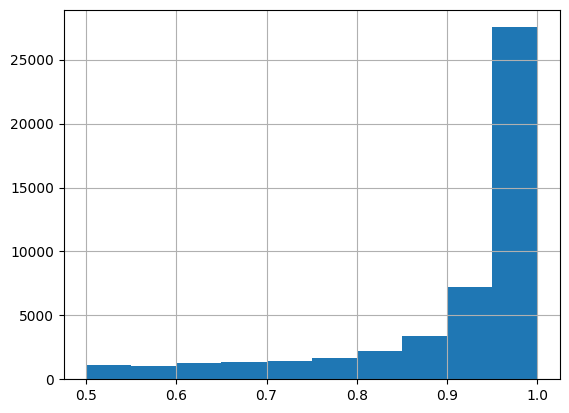

In [149]:
df.score.hist()

In [150]:
df.head(20)

,id,chat_id,text,classification,score
0,3,1,Poderiam me ajudar?,NEGATIVE,0.985339
1,17,2,poderiam me ajudar ?,NEGATIVE,0.985339
2,20,2,gostaria de saber se tem como eu remover a res...,NEGATIVE,0.919400
3,21,2,"caso não possa ser removido, tem alguma maneir...",NEGATIVE,0.990002
4,24,2,"quer dizer, me refiro as mensagens do chatbot",NEGATIVE,0.979403
5,26,2,no caso eu queria remover ela só pra um usuário,NEGATIVE,0.990147
6,27,2,é possível ?,NEGATIVE,0.971585
7,29,2,"seria esta mensagem ""\nEsse telefone não receb...",NEGATIVE,0.978365
8,31,2,quero que desative essa mensagem só pro usuári...,NEGATIVE,0.918393
9,32,2,pois esse número está errado e ainda estamos v...,NEGATIVE,0.931621


In [151]:
# df['id'] = bert_period_break_df['id']
df.text.isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
48356    False
48357    False
48358    False
48359    False
48360    False
Name: text, Length: 48227, dtype: bool

In [152]:
bert_period_break_df.iloc[99]

id               3027
chat_id            16
text       Pq não 31?
Name: 100, dtype: object

Export dataframe as CSV

In [153]:
df.to_json('default_bert_data', orient='records',lines=True,force_ascii=False)

## Sentiment Analysis using BERTimbau

Creation of Bertimbau pipeline:

In [154]:
from transformers import BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

pipe = pipeline(task='sentiment-analysis', model='neuralmind/bert-base-portuguese-cased', tokenizer=tokenizer)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [214]:
pipe('Eu estou extremamente feliz!!')

[{'label': 'LABEL_0', 'score': 0.5385656952857971}]

In [155]:
%%time
df_bertimbau = bert_df.assign(
    classification=bert_df['text'].apply(lambda x: pipe(x)[0]['label']),
    score=bert_df['text'].apply(lambda x: pipe(x)[0]['score'])
)

CPU times: total: 4h 42min 15s
Wall time: 44min 34s


In [156]:
df_bertimbau.head(10)

,id,chat_id,text,classification,score
0,3,1,Poderiam me ajudar?,LABEL_1,0.515115
1,17,2,poderiam me ajudar ?,LABEL_1,0.520017
2,20,2,gostaria de saber se tem como eu remover a res...,LABEL_0,0.509301
3,21,2,"caso não possa ser removido, tem alguma maneir...",LABEL_0,0.521928
4,24,2,"quer dizer, me refiro as mensagens do chatbot",LABEL_0,0.519252
5,26,2,no caso eu queria remover ela só pra um usuário,LABEL_0,0.516763
6,27,2,é possível ?,LABEL_1,0.500711
7,29,2,"seria esta mensagem ""\nEsse telefone não receb...",LABEL_0,0.549547
8,31,2,quero que desative essa mensagem só pro usuári...,LABEL_0,0.505608
9,32,2,pois esse número está errado e ainda estamos v...,LABEL_0,0.530190


<Axes: >

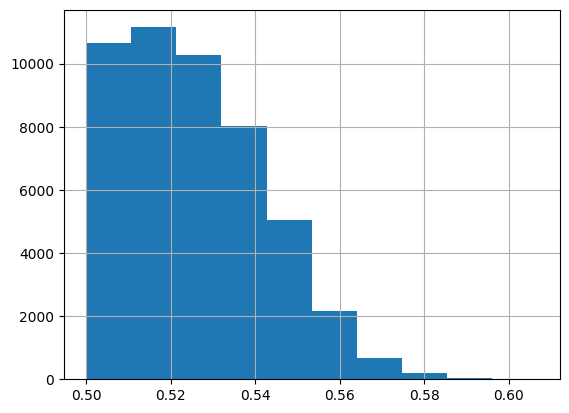

In [157]:
df_bertimbau.score.hist()

In [158]:
df_bertimbau.to_json('bertimbau_data', orient='records',lines=True,force_ascii=False)

## Sentiment Analysis using LeIA (Vader for PT-Br)

Create instance of Sentiment Intensity Analyzer from LeIA lib:

In [159]:
from LeIA import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [160]:
def extract_leia_sentiment(compound):
    sent_output = {'label':'', 'new_score':0}    
    
    sent_output['new_score'] = (compound + 1) / 2
    
    if compound == 0:
        sent_output['label'] = 'NEUTRAL'
    elif compound > 0.2:
        sent_output['label'] = 'POSITIVE'        
    elif compound > 0:
        sent_output['label'] = 'NEUTRAL POSITIVE'        
    elif compound >= -0.2 :
        sent_output['label'] = 'NEUTRAL NEGATIVE'
    else:
        sent_output['label'] = 'NEGATIVE'
        
    return sent_output
        

In [162]:
%%time
df_leia = bert_df.assign(
    score=bert_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
)


CPU times: total: 4.75 s
Wall time: 4.96 s


In [163]:
df_leia = df_leia.assign(
    normalized_score=df_leia['score'].apply(lambda x: extract_leia_sentiment(x)['new_score']),
    label = df_leia['score'].apply(lambda x: extract_leia_sentiment(x)['label']),
)


In [164]:
df_leia.head(10)

,id,chat_id,text,score,normalized_score,label
0,3,1,Poderiam me ajudar?,0.0000,0.5000,NEUTRAL
1,17,2,poderiam me ajudar ?,0.0000,0.5000,NEUTRAL
2,20,2,gostaria de saber se tem como eu remover a res...,0.0000,0.5000,NEUTRAL
3,21,2,"caso não possa ser removido, tem alguma maneir...",-0.2960,0.3520,NEGATIVE
4,24,2,"quer dizer, me refiro as mensagens do chatbot",0.0772,0.5386,NEUTRAL POSITIVE
5,26,2,no caso eu queria remover ela só pra um usuário,0.0000,0.5000,NEUTRAL
6,27,2,é possível ?,0.3182,0.6591,POSITIVE
7,29,2,"seria esta mensagem ""\nEsse telefone não receb...",-0.3612,0.3194,NEGATIVE
8,31,2,quero que desative essa mensagem só pro usuári...,0.0000,0.5000,NEUTRAL
9,32,2,pois esse número está errado e ainda estamos v...,-0.3612,0.3194,NEGATIVE


<Axes: >

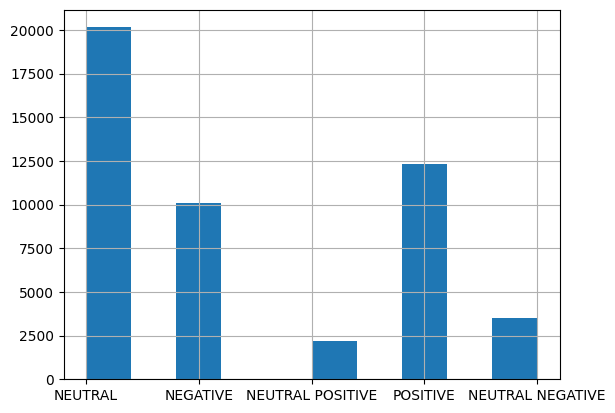

In [165]:
df_leia.label.hist()

<Axes: >

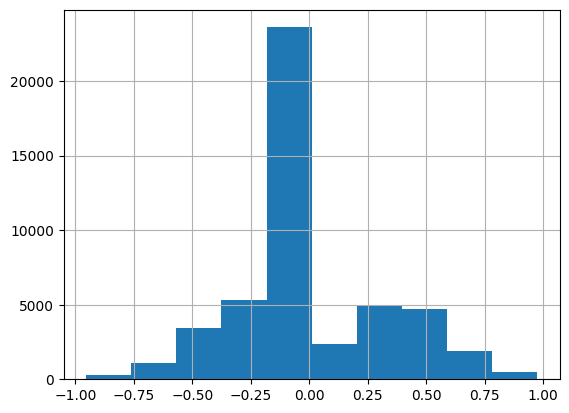

In [166]:
df_leia.score.hist()

In [167]:
df_leia.to_json('leia_data', orient='records',lines=True,force_ascii=False)

## Method Comparison

In [230]:
leia_df = pd.read_json('leia_data', lines=True)
bertimbau_df = pd.read_json('bertimbau_data', lines=True)
bert_df = pd.read_json('default_bert_data', lines=True)

print("Dataframes' shapes")
print(f"Leia: {leia_df.shape}/ Bertimbau: {bertimbau_df.shape}/ Bert: {bert_df.shape}")

Dataframes' shapes
Leia: (48227, 6)/ Bertimbau: (48227, 5)/ Bert: (48227, 5)


In [231]:
bertimbau_df.head(1)

,id,chat_id,text,classification,score
0,3,1,Poderiam me ajudar?,LABEL_1,0.515115


In [232]:
bert_df.head(1)

,id,chat_id,text,classification,score
0,3,1,Poderiam me ajudar?,NEGATIVE,0.985339


In [233]:
comparison_df = leia_df.copy()
comparison_df.head()

,id,chat_id,text,score,normalized_score,label
0,3,1,Poderiam me ajudar?,0.0000,0.5000,NEUTRAL
1,17,2,poderiam me ajudar ?,0.0000,0.5000,NEUTRAL
2,20,2,gostaria de saber se tem como eu remover a res...,0.0000,0.5000,NEUTRAL
3,21,2,"caso não possa ser removido, tem alguma maneir...",-0.2960,0.3520,NEGATIVE
4,24,2,"quer dizer, me refiro as mensagens do chatbot",0.0772,0.5386,NEUTRAL POSITIVE


In [234]:
comparison_df.rename(columns = {'score':'leia_score','normalized_score':'leia_normalized_score','label':'leia_class'}, inplace=True)

In [235]:
comparison_df['bertimbau_class'] = bertimbau_df['classification']
comparison_df['bertimbau_score'] = bertimbau_df['score']
comparison_df['bert_class'] = bert_df['classification']
comparison_df['bert_score'] = bert_df['score']

In [236]:
comparison_df.head()

,id,chat_id,text,leia_score,leia_normalized_score,leia_class,bertimbau_class,bertimbau_score,bert_class,bert_score
0,3,1,Poderiam me ajudar?,0.0000,0.5000,NEUTRAL,LABEL_1,0.515115,NEGATIVE,0.985339
1,17,2,poderiam me ajudar ?,0.0000,0.5000,NEUTRAL,LABEL_1,0.520017,NEGATIVE,0.985339
2,20,2,gostaria de saber se tem como eu remover a res...,0.0000,0.5000,NEUTRAL,LABEL_0,0.509301,NEGATIVE,0.919400
3,21,2,"caso não possa ser removido, tem alguma maneir...",-0.2960,0.3520,NEGATIVE,LABEL_0,0.521928,NEGATIVE,0.990002
4,24,2,"quer dizer, me refiro as mensagens do chatbot",0.0772,0.5386,NEUTRAL POSITIVE,LABEL_0,0.519252,NEGATIVE,0.979403


In [237]:
comparison_df = comparison_df[['id','chat_id','text','leia_class','bert_class','bertimbau_class','leia_score','bert_score','bertimbau_score']]

In [238]:
comparison_df.head()

,id,chat_id,text,leia_class,bert_class,bertimbau_class,leia_score,bert_score,bertimbau_score
0,3,1,Poderiam me ajudar?,NEUTRAL,NEGATIVE,LABEL_1,0.0000,0.985339,0.515115
1,17,2,poderiam me ajudar ?,NEUTRAL,NEGATIVE,LABEL_1,0.0000,0.985339,0.520017
2,20,2,gostaria de saber se tem como eu remover a res...,NEUTRAL,NEGATIVE,LABEL_0,0.0000,0.919400,0.509301
3,21,2,"caso não possa ser removido, tem alguma maneir...",NEGATIVE,NEGATIVE,LABEL_0,-0.2960,0.990002,0.521928
4,24,2,"quer dizer, me refiro as mensagens do chatbot",NEUTRAL POSITIVE,NEGATIVE,LABEL_0,0.0772,0.979403,0.519252


In [239]:
def rename_bertimbau_classification(classification):
    if classification == 'LABEL_0':
        return 'NEGATIVE'
    else:
        return 'POSITIVE'

In [240]:
comparison_df.bertimbau_class = comparison_df.bertimbau_class.apply(lambda x: rename_bertimbau_classification(x))
comparison_df.head()

,id,chat_id,text,leia_class,bert_class,bertimbau_class,leia_score,bert_score,bertimbau_score
0,3,1,Poderiam me ajudar?,NEUTRAL,NEGATIVE,POSITIVE,0.0000,0.985339,0.515115
1,17,2,poderiam me ajudar ?,NEUTRAL,NEGATIVE,POSITIVE,0.0000,0.985339,0.520017
2,20,2,gostaria de saber se tem como eu remover a res...,NEUTRAL,NEGATIVE,NEGATIVE,0.0000,0.919400,0.509301
3,21,2,"caso não possa ser removido, tem alguma maneir...",NEGATIVE,NEGATIVE,NEGATIVE,-0.2960,0.990002,0.521928
4,24,2,"quer dizer, me refiro as mensagens do chatbot",NEUTRAL POSITIVE,NEGATIVE,NEGATIVE,0.0772,0.979403,0.519252


Foi feita a comparação das saídas entre si e com os resultados oriundos do ChatGPT. Com isso, foi observado que o modelo mais acurado em relação ao ChatGPT (um modelo treinado em extensos bancos de dados) foi o LeIA.

Sendo assim, esse foi o modelo escolhido para a rotulação inicial de todo o banco de dados, incluindo treino e teste.

O tratamento de dados desses bancos será feito no notebook: LeIA Training